In [1]:
import os, time, errno
import torch, tables
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='2'
savedir = '32x32-convnet'

In [3]:
T = 10 # time buckets

hdf5 = tables.open_file('captures/fei/R1_E3_AMES_200min_200f_14l_rgb.h5','r')
hdf5 = hdf5.root

try:
    dataset = np.load('captures/fei/cache.npy')
except FileNotFoundError:

    data = []
    for i in range(7):
        print('.',end='')
        batch = np.array(hdf5['data'][i*400:(i+1)*400])
        batch = batch.reshape(-1,T,int(batch.shape[1]/T),64,64,6).sum(2).astype(np.float32) # binning
        data.append(batch)
        
    dataset = np.concatenate(data,axis=0)
    dataset = np.moveaxis(dataset,[0,1,2,3,4],[0,1,3,4,2])
    np.save('captures/fei/cache.npy', dataset)
    
classes = np.array([np.array(itm.decode('utf-8').split('"'))[[1,3]].astype(np.int32)
                    for itm in np.array(hdf5['image_classes'].read())])

# Presented targets

In [4]:
imgs = hdf5["images"][0:100]
y,x = np.where(np.mean(imgs, axis=(0,3))>5)
xleft, xright, ytop, ybot = min(x), max(x), min(y), max(y)

images = hdf5["images"][:,ytop:ybot,xleft:xright]

tiny_images = []
for i in range(len(images)):
    tiny_images.append(cv2.resize(images[i],(64,64)))
images = np.stack(tiny_images)

# Model

In [5]:
class Block(torch.nn.Module):
    def __init__(self, filters):
        super(Block, self).__init__()
        
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters), torch.nn.ReLU(),
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters))
        
    def forward(self, x):
        return F.relu(x + self.block(x))
    
class ConvNet(torch.nn.Module):
    def __init__(self, filters=512):
        super(ConvNet, self).__init__()
        self.filters = filters
        
        self.conv_in = torch.nn.Conv2d(10*6, filters, 9, padding=4, stride=4, bias=False)
        
        self.resnet = torch.nn.ModuleList()
        for i in range(101): self.resnet.append(Block(filters))
            
        self.conv_out =  torch.nn.ConvTranspose2d(self.filters, 1, 8, stride=8, bias=True)
        self.bias = torch.nn.Parameter(torch.Tensor(64,64))
        
        for name, parm in self.named_parameters():
            if name.endswith('weight'): torch.nn.init.normal_(parm, 0, .01)
            if name.endswith('bias'): torch.nn.init.constant_(parm, 0.0)
    
    def forward(self, x):
        x = x.view(-1,10*6,64,64)[:,:,::2,::2].contiguous()
        zx = F.relu(self.conv_in(x))
        for layer in self.resnet: zx = layer(zx)
        return torch.sigmoid(self.conv_out(zx).squeeze() + self.bias[None,:,:])

# Fit

In [6]:
data = torch.tensor(dataset)/30. # scaling
targets = torch.tensor(images).float().mean(3)/255.

In [7]:
train_data = data[[i for i in range(2800) if (i+1)%5 != 0]]
val_data = data[slice(4,2800,10)]
test_data = data[slice(9,2800,10)]

train_targets = targets[[i for i in range(2800) if (i+1)%5 != 0]]
val_targets = targets[slice(4,2800,10)]
test_targets = targets[slice(9,2800,10)]

In [8]:
batch_size = 8

model = ConvNet().cuda()
count = sum([np.prod(parm.shape) for parm in model.parameters() if parm.requires_grad])
print('Initialized a graph with {} parameters'.format(count))

train_history = []
val_history = []

model.eval()
loss = 0.
for i in np.random.permutation(len(val_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).sum(1).mean()
val_history.append(loss/(len(val_data)//batch_size))
print('Initial Loss: {:2f}'.format(val_history[-1]))

Initialized a graph with 479309825 parameters
Initial Loss: 4.071684


In [9]:
batch_size = 8
optimizer = torch.optim.Adam(model.parameters(), lr=.0003)

try:
    print('epoch\ttrain loss\ttest loss\ttime\t\tutime')
    t0 = time.time()
    for epoch in range(500):
        model.train()
        loss_train = 0
        for i in np.random.permutation(len(train_data)//batch_size):
            start, end = i*batch_size, (i+1)*batch_size
            x,z = train_data[start:end].cuda(), train_targets[start:end].cuda()
            loss = ((model(x) - z)**2).sum(1).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.detach()
        train_history.append(loss_train/(len(train_data)//batch_size))

        if epoch % 1 == 0:
            t1 = time.time()
            model.eval()
            loss = 0.
            for i in range(len(val_data)//batch_size):
                start, end = i*batch_size, (i+1)*batch_size
                x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
                loss += ((model(x).detach() - z)**2).sum(1).mean()
            val_history.append(loss/(len(val_data)//batch_size))
            print('{:d}\t{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(epoch,train_history[-1],val_history[-1],time.time()-t0, time.time()-t1))
            t0 = time.time()
            
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print('Finished')

epoch	train loss	test loss	time		utime
0	1.398226	1.516140	84.139415	2.243624
1	0.970618	1.371700	88.877902	2.345763
2	0.816372	1.490048	89.796126	2.345280
3	0.697714	1.444257	89.903854	2.337509
4	0.605240	0.943744	89.796186	2.335584
5	0.546527	1.026045	89.820557	2.336786
6	0.490524	1.079784	89.716480	2.331722
7	0.454781	1.074266	89.140390	2.338848
8	0.419120	0.984200	89.003442	2.341055
9	0.390139	0.868331	89.186036	2.333311
10	0.367096	0.956513	89.603557	2.343949
11	0.339908	0.925879	90.024986	2.350569
12	0.317615	0.829805	90.049556	2.381849
13	0.306221	1.019615	90.261503	2.358108
14	0.288411	0.889144	89.903518	2.338284
15	0.273836	0.949013	89.531961	2.337867
16	0.265504	0.884079	89.153063	2.342046
17	0.246323	0.900753	89.125142	2.341960
18	0.230665	0.895868	88.856033	2.329730
19	0.220644	0.783197	88.540767	2.339396
20	0.212757	0.807114	88.727485	2.331562
21	0.202726	0.925279	89.154356	2.339212
22	0.196577	0.955052	89.436812	2.345488
23	0.186862	0.824892	89.556897	2.331290
24	0.178717

202	0.007152	0.759124	90.302346	2.369649
203	0.007132	0.839774	90.610171	2.386634
204	0.006612	0.770385	90.725408	2.384213
205	0.006005	0.789682	90.685988	2.380641
206	0.005516	0.800393	90.623178	2.382576
207	0.005558	0.772310	90.370940	2.340914
208	0.005816	0.749063	90.088834	2.346448
209	0.006230	0.760326	90.218157	2.366556
210	0.006434	0.760531	90.352599	2.379242
211	0.006466	0.800845	90.712497	2.379805
212	0.006358	0.764175	90.680578	2.389858
213	0.006455	0.835492	90.692134	2.388802
214	0.006259	0.852486	90.688125	2.384198
215	0.005913	0.750935	90.233360	2.343463
216	0.005740	0.753024	90.143432	2.343304
217	0.005598	0.725354	90.218388	2.350007
218	0.005645	0.767279	90.447845	2.382787
219	0.005869	0.753338	90.706072	2.379257
220	0.006052	0.752600	90.698381	2.395622
221	0.006073	0.756206	90.694982	2.376987
222	0.005937	0.782586	90.687588	2.367738
223	0.005701	0.842035	90.177661	2.340329
224	0.005482	0.885479	90.160282	2.350678
225	0.005315	0.756752	90.265408	2.368690
226	0.005035	0.8

402	0.002829	0.757232	90.386554	2.386602
403	0.002849	0.752921	90.353134	2.364563
404	0.002749	0.776779	90.397509	2.385458
405	0.002701	0.719942	90.421026	2.374366
406	0.002561	0.757566	90.409775	2.366743
407	0.002465	0.726263	90.394718	2.373948
408	0.002462	0.745247	90.356661	2.367986
409	0.002490	0.816260	90.417369	2.378628
410	0.002627	0.779432	90.392465	2.390563
411	0.002833	0.742485	90.406645	2.383677
412	0.002898	0.781123	90.382962	2.384818
413	0.002922	0.870502	90.415954	2.374348
414	0.002752	0.736440	90.340879	2.383390
415	0.002695	0.789689	90.417081	2.376540
416	0.002733	0.752927	90.348241	2.388548
417	0.002616	0.734954	90.427909	2.380423
418	0.002517	0.873643	90.401426	2.376216
419	0.002431	0.743394	90.376526	2.369436
420	0.002360	0.756560	90.378241	2.375612
421	0.002466	0.738591	90.379069	2.368562
422	0.002513	0.779367	90.363500	2.383076
423	0.002565	0.769605	90.401675	2.381047
424	0.002649	0.810526	90.366130	2.370052
425	0.002694	0.814586	90.371254	2.378918
426	0.002595	0.7

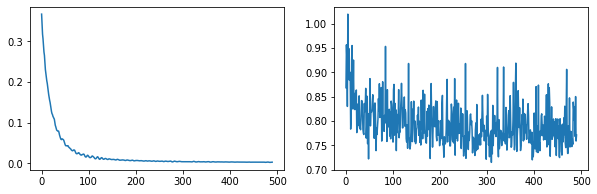

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].plot([itm.cpu().numpy() for itm in train_history[10:]])
ax[1].plot([itm.cpu().numpy() for itm in val_history[10:]])

In [11]:
model.eval()
loss = 0.
for i in np.random.permutation(len(test_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = test_data[start:end].cuda(), test_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).view(-1,64*64).sum(1).mean()
print('Final Loss: {:2f}'.format(loss/(len(test_data)//batch_size)))

Final Loss: 48.348248


In [12]:
try:
    os.makedirs(f'final-outputs/{savedir}')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

originals = False
try:
    os.makedirs('final-outputs/originals')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    originals = True

train_idx = 0
val_idx = 0
test_idx = 0
for i in range(len(data)):
    person, pose = classes[i]
    if (i+1) % 5 != 0: # training data
        prefix = f'train{train_idx}'
        train_idx += 1
    elif (i+1) % 10 == 5: # validation data
        prefix = f'valid{val_idx}'
        val_idx += 1
    else: # (i+1) % 10 == 0 (test data)
        prefix = f'test{test_idx}'
        test_idx += 1
    
    recon = model(data[i].cuda()).detach().cpu().numpy()[0]
    cv2.imwrite(f'final-outputs/{savedir}/{prefix}-person{person}-pose{pose}.png', 255*recon)
    if not originals:
        cv2.imwrite(f'final-outputs/originals/{prefix}-person{person}-pose{pose}.png', 255*targets[i].numpy())

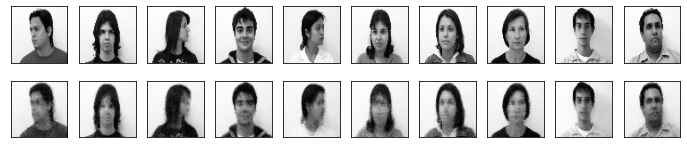

In [13]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(train_data[0:10].cuda()).detach().cpu()
for i in range(10):
    ax[0,i].imshow(train_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])

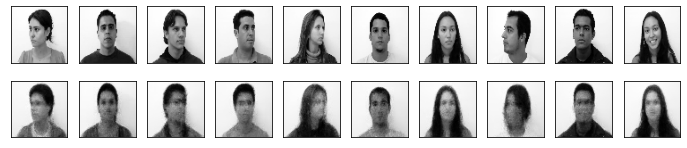

In [14]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(test_data[0:10].cuda()).detach().cpu()
for i in range(10):    
    ax[0,i].imshow(test_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])